In [4]:
import os
import camelot
import pandas as pd

In [5]:

def load_tables_from_pdf(pdf_path, pages):
    tables = camelot.read_pdf(pdf_path, pages=pages, flavor='stream')
    return tables

def transform_tables_to_df(tables):
    df = pd.DataFrame()
    for table in tables:
        df = df.append(table.df)
        
    #ignore the first two rowns and use the third row as column names
    df.columns = df.iloc[1]
    df = df.iloc[2:]
    df = df.reset_index(drop=True) #reset index
    return df

# taje in a text file and return a df
def read_leuven_norms_as_df(path):
    if 'ANIMALS' not in path:
        #read txt file with utf-8 encoding
        df = pd.read_csv(path, sep='\t', encoding='ISO-8859-1"')
    else:
        df = pd.read_csv(path, sep='\t')
    return df

In [6]:
# load pdf file from data folder and extract tables
tables = load_tables_from_pdf('../data/r5_ecoset_Supplemental_Appendix_Table.pdf', '1-end')
df_ecoset = transform_tables_to_df(tables)
ecoset_concepts = [i if i not in ['', 'category name', ' '] else i for i in df_ecoset['category name'].values]

In [7]:
leuven_animals = read_leuven_norms_as_df('../data/LeuvenNorms/ANIMALSexemplarfeaturesbig.txt')
leuven_artifacts = read_leuven_norms_as_df('../data/LeuvenNorms/ARTIFACTSexemplarfeaturesbig.txt')
leuven_animals_names = list(leuven_animals.columns[2:])
leuven_artifacts_names = list(leuven_artifacts.columns[2:])
leuven_concepts = leuven_animals_names + leuven_artifacts_names

In [8]:
# find the overlap between ecoset and leuven
overlap = [i for i in ecoset_concepts if i in leuven_concepts]

# Ecoset overlap

In [9]:
# subset df_ecoset to only include the overlap elements in the column 'category name'
df_ecoset_overlap = df_ecoset[df_ecoset['category name'].isin(overlap)]

# find the sum of the values in the column # of\nimages
# first convert the values in the column to int
df_ecoset_overlap['# of\nimages'] = df_ecoset_overlap['# of\nimages'].astype(int)
# then sum the values
sum(df_ecoset_overlap['# of\nimages'])

/Users/siddharthsuresh/miniconda3/envs/vision_robustness_using_semantic_norms/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


314935

In [11]:
# Check the correlation between columns FCI nad # of\nimages
df_ecoset_overlap['FCI'] = df_ecoset_overlap['FCI'].astype(float)
df_ecoset_overlap['# of\nimages'] = df_ecoset_overlap['# of\nimages'].astype(int)
df_ecoset_overlap[['FCI', '# of\nimages']].corr()

# Check if this correlation is significant
from scipy.stats import pearsonr
pearsonr(df_ecoset_overlap['FCI'], df_ecoset_overlap['# of\nimages'])

/Users/siddharthsuresh/miniconda3/envs/vision_robustness_using_semantic_norms/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/siddharthsuresh/miniconda3/envs/vision_robustness_using_semantic_norms/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(0.32977560410982093, 0.001930693260040591)

# Leuven

In [10]:
#combine the leuven_animals and leuven_artifacts, the first column in leuven_animals is feature/_exemplar_ENGLISH and the first column in leuven_artifacts is Item

leuven_animals = leuven_animals.rename(columns={'feature/_exemplar_ENGLISH': 'Item'})
leuven = pd.concat([leuven_animals, leuven_artifacts], axis=0, ignore_index=True)

#replace all the NaN values with 0
leuven = leuven.fillna(0)

#divide all values by FFrq column
leuven = leuven.iloc[:, 2:].div(leuven['FFrq'], axis=0)

#transpose the df
leuven = leuven.T

## Tree plot with mds

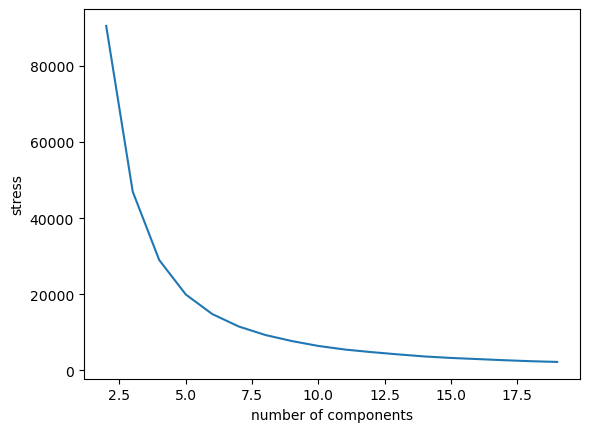

In [11]:
# do mds on the leuven df with dimension ranging from 2 to 10 to find the best dimension for the mds by plotting the stress on the y-axis and the number of dimensions on the x-axis

from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt
import numpy as np

# calculate the distance matrix
distance_matrix = euclidean_distances(leuven)

# do mds on the distance matrix with dimension ranging from 2 to 10 to find the best dimension for the mds by plotting the stress on the y-axis and the number of dimensions on the x-axis
stress = []
for i in range(2, 20):
    mds = MDS(n_components=i, dissimilarity='precomputed')
    mds.fit(distance_matrix)
    stress.append(mds.stress_)

plt.plot(range(2, 20), stress)
plt.xlabel('number of components')
plt.ylabel('stress')
plt.show()


In [12]:
#do mds on the leuven data and set the rownames of leuven as the index of the mds
from sklearn.manifold import MDS
mds = MDS(n_components=6, random_state=0)
leuven_mds = mds.fit_transform(leuven)
leuven_mds = pd.DataFrame(leuven_mds, index=leuven.index)

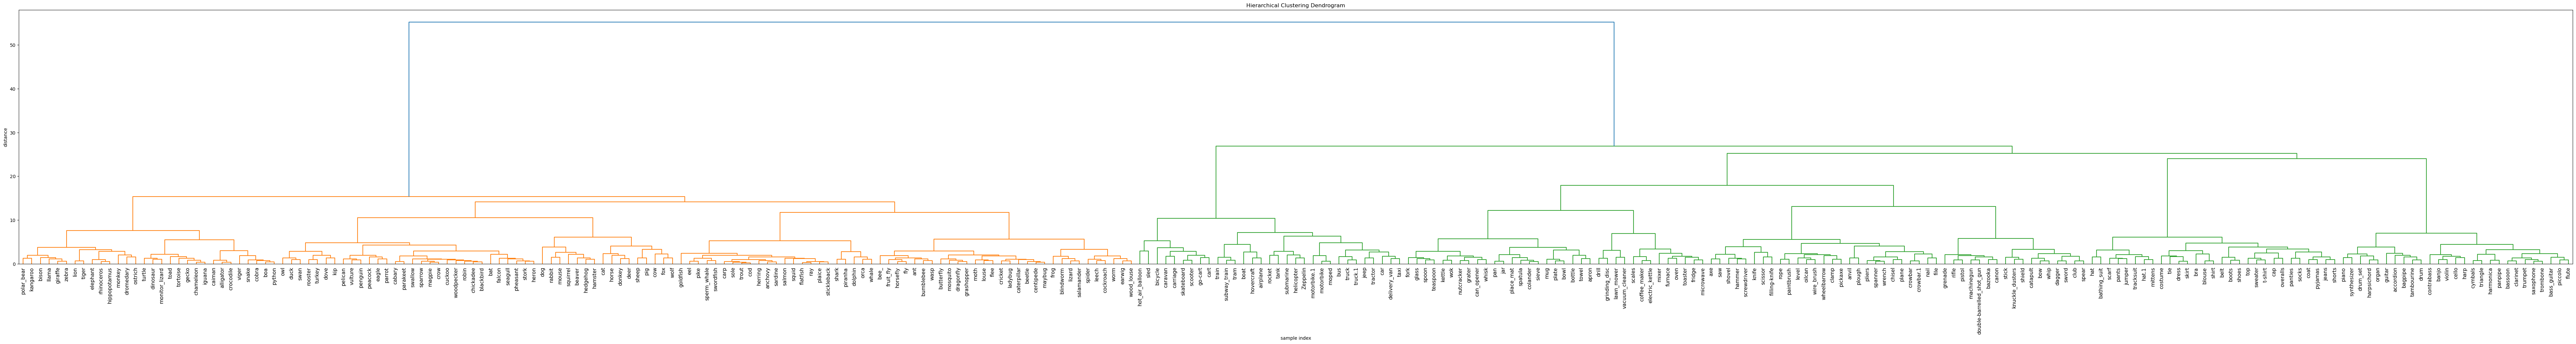

In [13]:
#visualize the mds as a tree plot and add leuven_mds index as the labels
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import inconsistent
from scipy.cluster.hierarchy import maxdists


def plot_dendogram(embedding_matrix, labels, title = 'Hierarchical Clustering Dendrogram', figsize=(100, 10)):
    Z = linkage(embedding_matrix, 'ward')
    plt.figure(figsize = figsize)
    plt.title(title)
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=11.,  # font size for the x axis labels
        labels=labels
    )
    plt.show()

plot_dendogram(leuven_mds, labels = leuven_mds.index, figsize=(100, 10))

# Ecoset, leuven overlap Look at number of images per class

## dendogram of overlap categories

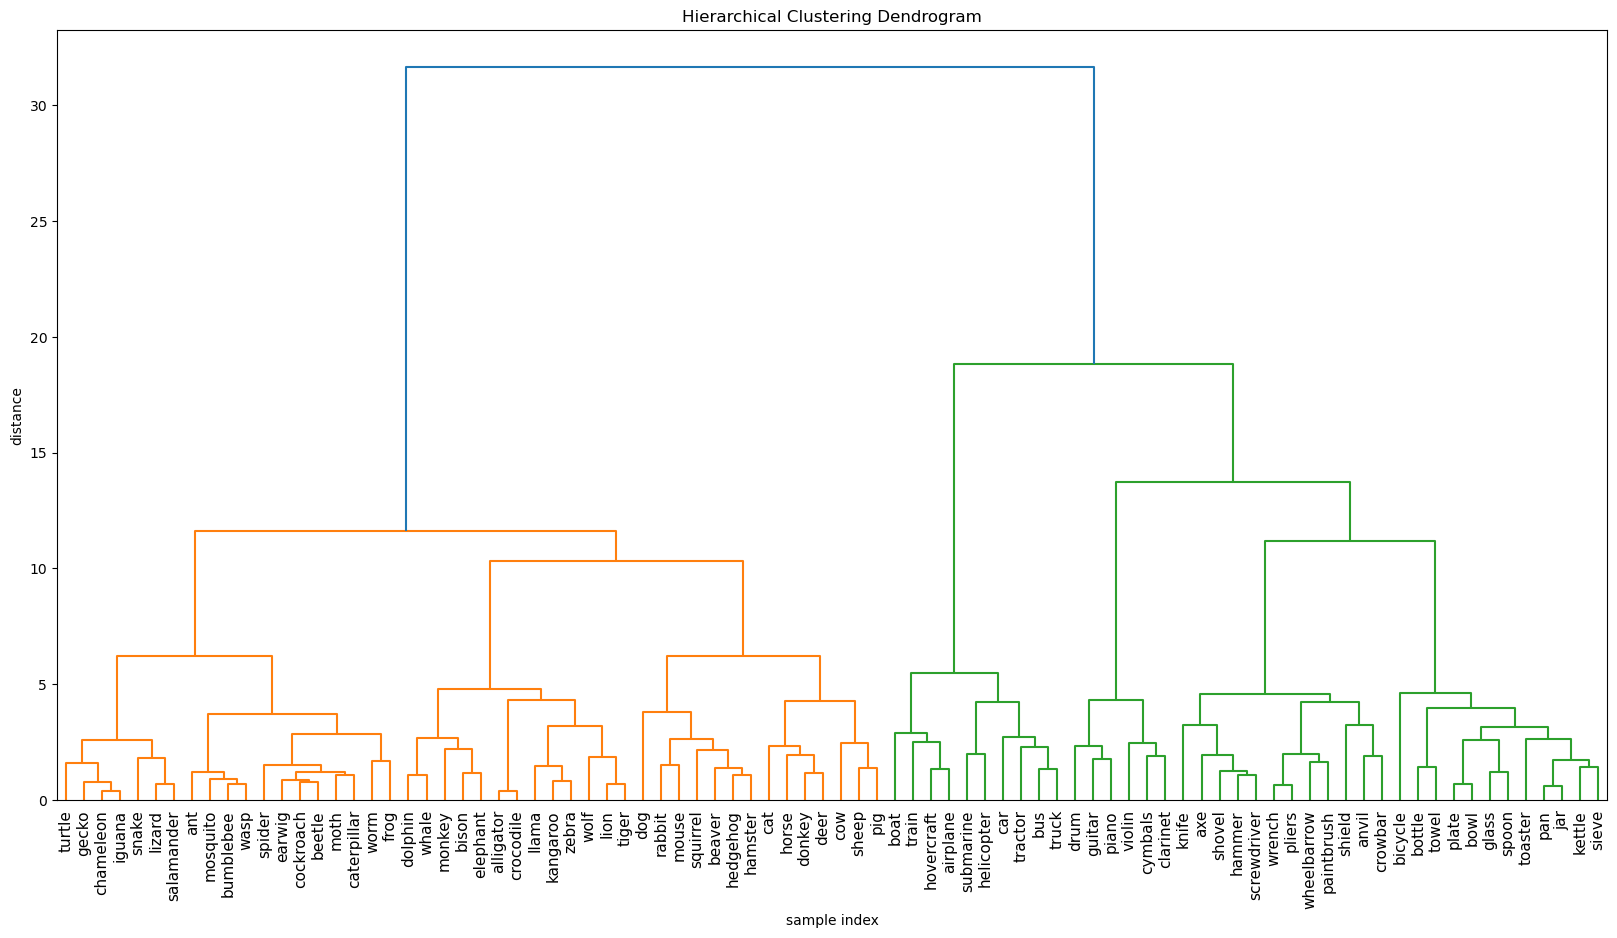

In [20]:
# make a new df from leuven mds and chose index that exist in df_ecoset_overlap
leuven_mds_overlap = leuven_mds[leuven_mds.index.isin(df_ecoset_overlap['category name'])]

# plot hierarchical clustering dendrogram of the leuven_mds_overlap
plot_dendogram(leuven_mds_overlap, labels = leuven_mds_overlap.index, figsize=(20, 10))


## Training data size, split

In [23]:
# sum the values in the column # of\nimages in df_ecoset_overlap
df_ecoset_overlap['# of\nimages'] = df_ecoset_overlap['# of\nimages'].astype(int)
sum(df_ecoset_overlap['# of\nimages'])

/Users/siddharthsuresh/miniconda3/envs/vision_robustness_using_semantic_norms/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


314935

# Make the dataset